# Project: Dog Breed Identificaiton App powered by Convolutional Neural Networks

### Udacity Data Scientist Nanodegree

### Contents
#### [Project Definition](#pjt_def)
#### [Analysis](#analysis)

* [Step 0](#step0): Import Datasets and Data Exploration
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='pjt_def'></a>
## Project Definition
This project aims at constructing an algorithm to classify images of dogs and human faces according to dog's breed. The algorithm development is intended to be used as part of a web or mobile app, which accepts any user-supplied image as input and provides an estimated of the dog's breed name for either dog or human-face image. 

This notebook was developed largely based on the template codes provided by the Udacity. The data sources wwere also provided by the Udacity. Please refer to README for downloading and setting up the necessary files to run this notebook at local machine.

<a id='step0'></a>
## Step 0: Import Datasets and Data Exploration

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
import pandas as pd
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    dog_ide = pd.DataFrame(data['target'], columns=['id_breed'])
    return dog_files, dog_targets, dog_ide

# load train, test, and validation datasets
train_files, train_targets, train_de = load_dataset('../../../data/dog_images/train')
valid_files, valid_targets, valid_de = load_dataset('../../../data/dog_images/valid')
test_files, test_targets, test_de = load_dataset('../../../data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("../../../data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Data Exploration and Visualization

This section will look at the data distribution with respect to dog breed.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

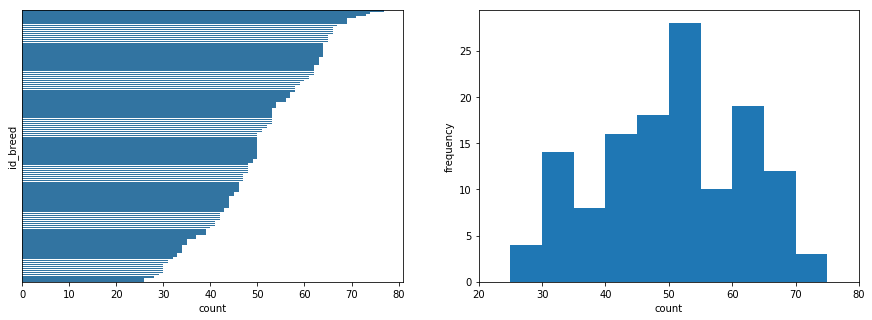

In [7]:
# plot only for training dateset
x = train_de['id_breed'].unique()
y = train_de['id_breed'].value_counts()
breed_order = y.index
base_color = sns.color_palette()[0]

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.countplot(data=train_de, y='id_breed', color=base_color, order=breed_order)
plt.yticks([])

plt.subplot(1,2,2)
bins = np.arange(0, max(y), 5)
plt.hist(y, bins=bins)
plt.xlim(20,80)
plt.xlabel('count')
plt.ylabel('frequency')
plt.show()

In [8]:
# descrtive statistical info of sample size for each breed. 
y.describe()

count    133.000000
mean      50.225564
std       11.863885
min       26.000000
25%       42.000000
50%       50.000000
75%       61.000000
max       77.000000
Name: id_breed, dtype: float64

* It is clear that number of sample (size) for each breed is very small (counts 26-77), indicating that we should utilize transfer learning as well as data augmentation to address this challenge.
* The distribution of size of dataset for each breed has peaks in the mean value, but also shows smaller ones.

### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [3]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("../../../data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


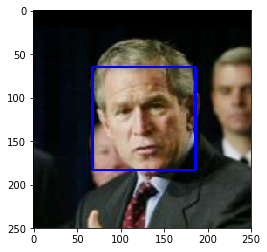

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[4])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [6]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

In [13]:
def assess_face_detetector(files, face_detector=face_detector):
    detected = 0
    for i in files:
        if face_detector(i):
            detected += 1
    rate = detected/len(files)*100
    print('{:.1f} % of images are with a detected human face'.format(rate))

In [14]:
# pass human files
assess_face_detetector(human_files_short)

# pass dog images
assess_face_detetector(dog_files_short)

100.0 % of images are with a detected human face
11.0 % of images are with a detected human face


__Answer:__ While the face detector recongized all of the human faces successfully, it also recognized 11% of dog images as human faces.

__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

Clearly, it is not always the case to recieve a clearly presented face from the user. Therefore, the more robust algorithm is needed to be ready for such images. The following different algorithms were tested:

* OpenCV has other pre-trained Casacade Cassifier such as LBP ([Local Binary Patterns](https://en.wikipedia.org/wiki/Local_binary_patterns)). 

* The other approach is to use deep learning. OpenCV has deep learning (dnn) module, which includes the Caffe-based face detector. This detector was also tested by following [this tutorial](https://pyimagesearch.com/2018/02/26/face-detection-with-opencv-and-deep-learning/). The trained model was downloaded from [here](https://github.com/spmallick/learnopencv/tree/master/FaceDetectionComparison).

In [15]:
# Test LBP Classifier
lbp_face_cascade = cv2.CascadeClassifier('haarcascades/lbpcascade_frontalface_improved.xml')  

In [16]:
def lbp_face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = lbp_face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [17]:
assess_face_detetector(human_files_short, face_detector=lbp_face_detector)

88.0 % of images are with a detected human face


In [18]:
assess_face_detetector(dog_files_short, face_detector=lbp_face_detector)

1.0 % of images are with a detected human face


* LBP classifier could not identify human face with 100% even on the LFW dataset. While it is lighther than Haar cascade classifier, it is does not serve for our purpose this time.

### Caffe-based human face detector
The other approach is to use deep learning. OpenCV has deep learning (dnn) module, which includes the Caffe-based face detector. Caffe is an open-source structure for CNN and uses text documents with the predefined design for characterizing the CNN’s construction. 

Given that the Caffe-based face detector required the latest OpenCV’s version, the below code did not work in the Udacity’s workspace (tested in the local PC). Thus, the code is presented as an exmpale.

As discussed in the technical report as well as in the sperate jupyter notebook, Caffe-based human face detector can identify images with not clearly presented faces and have lower rate of false postive especially with high boundary confidence.

In [8]:
### This function requres the latest version of OpenCV.
def face_detector_cnn(img_path, boundary=0.7):
    net = cv2.dnn.readNetFromCaffe('deploy.prototxt','res10_300x300_ssd_iter_140000_fp16.caffemodel') 
    # load the model and weights
    img = cv2.imread(img_path)
    (h, w) = img.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(img, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    # pass the blob through the net to detect faces
    net.setInput(blob)
    detections = net.forward() 
    # count draw boxes around the detected faces with the probability larger than the boundary
    faces = 0
    for i in range(0,detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > boundary:
            faces += 1
            # compute the (x, y) coordinates of the bounding box for the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            # draw the bounding box of the face along with the associated probability
            text = "{:.2f}%".format(confidence * 100)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.rectangle(img, (startX, startY), (endX, endY),(0, 0, 255), 2)
            cv2.putText(img, text, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
    
    print('Number of faces detected:{}'.format(faces))
    # show the output image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 2s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [24]:
def assess_dog_detetector(files):
    detected = 0
    for i in files:
        if dog_detector(i):
            detected += 1
    rate = detected/len(files)*100
    print('{:.1f} % of images are with a detected dog'.format(rate))

In [25]:
assess_dog_detetector(human_files_short)

0.0 % of images are with a detected dog


In [26]:
assess_dog_detetector(dog_files_short)

100.0 % of images are with a detected dog


* Pre-trained ResNet50 model detected dog with 100% accuracy for dog images and 0% of human faces images, indicating that this is much more accurate prediction model than ML-based cascade classifer that we tested in the above. 

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [11]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:08<00:00, 97.14it/s] 


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

In [14]:
# Construct Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential, Model

model = Sequential()

### TODO: Define your architecture.
'''
- Number of filters in each convolutional layer
The number of filters in the convlutional layer grows as it goes down deeper toward the output layer. 
This is because the number of low-level features is often quite low (e.g. cirlcs, squreas, lines etc). 
However, there are many different ways to combine them into higher-level or more complex features.
It is a common practice to double the number of filters after each pooling layer. Since a pooling layer
divides each spatial dimension by two, there will be lower risk of exploding the number of parameters.

- The inputs for the output Dense Layer must be flatten since a dense network expects a 1D array for each
instance, the number of which corrensponds to the number of breed type, 133. The global average pooling layer
outputs the meach of each feature map, dropping any remaining spatial information. Given that the challenge is 
classification task, it does not matter where the object is. Thanks to the global average pooling layer,
There is no need to include flatten and several fully connected layers before the output layer.

'''
model.add(Conv2D(filters=16, kernel_size=7, strides=(2,2), padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 112, 112, 16)      2368      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 56, 56, 32)        2080      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 64)        8256      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 128)       32896     
__________

### Compile the Model

In [15]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [16]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 30

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=32, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/30
6680/6680 [==============================] - 16s 2ms/step - loss: 4.8837 - acc: 0.0103 - val_loss: 4.8650 - val_acc: 0.0108
Epoch 2/30
6680/6680 [==============================] - 13s 2ms/step - loss: 4.8502 - acc: 0.0117 - val_loss: 4.8291 - val_acc: 0.0156
Epoch 3/30
6680/6680 [==============================] - 13s 2ms/step - loss: 4.8080 - acc: 0.0177 - val_loss: 4.7681 - val_acc: 0.0204
Epoch 4/30
6680/6680 [==============================] - 13s 2ms/step - loss: 4.7548 - acc: 0.0254 - val_loss: 4.7281 - val_acc: 0.0299
Epoch 5/30
6680/6680 [==============================] - 13s 2ms/step - loss: 4.7013 - acc: 0.0295 - val_loss: 4.6809 - val_acc: 0.0383
Epoch 6/30
6680/6680 [==============================] - 13s 2ms/step - loss: 4.6382 - acc: 0.0367 - val_loss: 4.6624 - val_acc: 0.0275
Epoch 7/30
6680/6680 [==============================] - 13s 2ms/step - loss: 4.5699 - acc: 0.0398 - val_loss: 4.5664 - val_acc: 0.0371
Epoch 8/

Epoch 28/30
6680/6680 [==============================] - 13s 2ms/step - loss: 3.4504 - acc: 0.1841 - val_loss: 3.7802 - val_acc: 0.1317
Epoch 29/30
6680/6680 [==============================] - 13s 2ms/step - loss: 3.4005 - acc: 0.1913 - val_loss: 4.0819 - val_acc: 0.1174
Epoch 30/30
6680/6680 [==============================] - 13s 2ms/step - loss: 3.3713 - acc: 0.1946 - val_loss: 3.7698 - val_acc: 0.1317


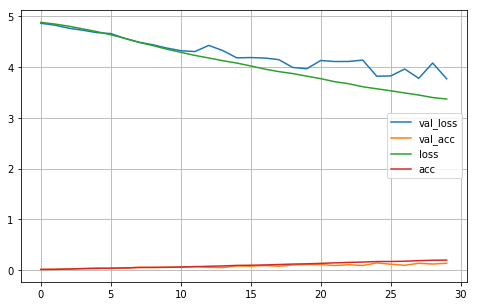

In [17]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

In [20]:
### train the model with image augmentation
from keras.preprocessing.image import ImageDataGenerator

aug_model = Sequential()

### TODO: Define your architecture.
aug_model.add(Conv2D(filters=16, kernel_size=7, strides=(2,2), padding='same', activation='relu', input_shape=(224, 224, 3)))
aug_model.add(MaxPooling2D(pool_size=2))
aug_model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
aug_model.add(MaxPooling2D(pool_size=2))
aug_model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
aug_model.add(MaxPooling2D(pool_size=2))
aug_model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
aug_model.add(MaxPooling2D(pool_size=2))
aug_model.add(GlobalAveragePooling2D())
aug_model.add(Dense(133, activation='softmax'))

aug_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 112, 112, 16)      2368      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 56, 56, 32)        2080      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 28, 28, 64)        8256      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 14, 14, 128)       32896     
__________

In [21]:
aug_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
# create and confiture augmented image generator
datagen_train = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

# fit augmented image generator on data
batch_size = 16
datagen_train.fit(train_tensors)

# train the model
checkpointer = ModelCheckpoint(filepath='saved_models/aug_weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
aug_history = aug_model.fit_generator(datagen_train.flow(train_tensors, train_targets,batch_size=batch_size),
                   steps_per_epoch=train_tensors.shape[0]//batch_size,
                   epochs=epochs, verbose=1, callbacks=[checkpointer],
                   validation_data=(valid_tensors, valid_targets),
                   validation_steps=valid_tensors.shape[0]//batch_size)

Epoch 1/30
417/417 [==============================] - 51s 122ms/step - loss: 4.8839 - acc: 0.0087 - val_loss: 4.8659 - val_acc: 0.0108
Epoch 2/30
417/417 [==============================] - 50s 121ms/step - loss: 4.8632 - acc: 0.0108 - val_loss: 4.8364 - val_acc: 0.0108
Epoch 3/30
417/417 [==============================] - 50s 121ms/step - loss: 4.8386 - acc: 0.0135 - val_loss: 4.8179 - val_acc: 0.0156
Epoch 4/30
417/417 [==============================] - 51s 122ms/step - loss: 4.8226 - acc: 0.0177 - val_loss: 4.8020 - val_acc: 0.0216
Epoch 5/30
417/417 [==============================] - 51s 121ms/step - loss: 4.8018 - acc: 0.0225 - val_loss: 4.7744 - val_acc: 0.0275
Epoch 6/30
417/417 [==============================] - 51s 122ms/step - loss: 4.7712 - acc: 0.0232 - val_loss: 4.7397 - val_acc: 0.0240
Epoch 7/30
417/417 [==============================] - 51s 121ms/step - loss: 4.7206 - acc: 0.0286 - val_loss: 4.6687 - val_acc: 0.0359
Epoch 8/30
417/417 [==============================] - 5

Epoch 27/30
417/417 [==============================] - 51s 121ms/step - loss: 3.6502 - acc: 0.1481 - val_loss: 3.7400 - val_acc: 0.1629
Epoch 28/30
417/417 [==============================] - 50s 121ms/step - loss: 3.6209 - acc: 0.1524 - val_loss: 3.7885 - val_acc: 0.1449
Epoch 29/30
417/417 [==============================] - 51s 121ms/step - loss: 3.5849 - acc: 0.1557 - val_loss: 3.8747 - val_acc: 0.1401
Epoch 30/30
417/417 [==============================] - 51s 121ms/step - loss: 3.5707 - acc: 0.1611 - val_loss: 3.6966 - val_acc: 0.1293


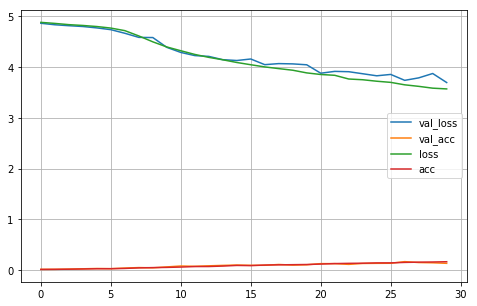

In [23]:
pd.DataFrame(aug_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

### Load and Test the Model with the Best Validation Loss without Image Augementation

In [32]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

In [33]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 13.2775%


* The test accuracy is greater than 1% but it's still very low. The limited sample size is the biggest obstacle for improving the accuracy in this case.
* Moreover, as obeserved in the learning curve, the decrease of validation loss starts decoupling with the training loss only after 10 epochs, indicating the overfitting.
* Thus, the transfer learning is a logical chose to improve the algorithm.

### Load and Test the Model with the Best Validation Loss With Image Augementation


In [34]:
aug_model.load_weights('saved_models/aug_weights.best.from_scratch.hdf5')

dog_breed_predictions = [np.argmax(aug_model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 14.1148%


* With Image augmentation, the model has produced higher accuracy.
* It seems that the image augmentation indeed mitigates the overfitting. The validation loss keeps steadily decreasing with the same degree as the training loss even after 10 epochs till 15-20 cycles.

---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [31]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

In [32]:
train_VGG16.shape[1:]

(7, 7, 512)

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [33]:
# Construct Model
VGG16_model = Sequential()

VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [34]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [35]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 291us/step - loss: 11.7519 - acc: 0.1359 - val_loss: 9.6820 - val_acc: 0.2587
Epoch 2/20
6680/6680 [==============================] - 2s 242us/step - loss: 9.2631 - acc: 0.3208 - val_loss: 9.0826 - val_acc: 0.3305
Epoch 3/20
6680/6680 [==============================] - 2s 243us/step - loss: 8.7663 - acc: 0.3819 - val_loss: 8.9990 - val_acc: 0.3581
Epoch 4/20
6680/6680 [==============================] - 2s 242us/step - loss: 8.4896 - acc: 0.4192 - val_loss: 8.7957 - val_acc: 0.3772
Epoch 5/20
6680/6680 [==============================] - 2s 242us/step - loss: 8.3416 - acc: 0.4409 - val_loss: 8.6263 - val_acc: 0.3796
Epoch 6/20
6680/6680 [==============================] - 2s 245us/step - loss: 8.2074 - acc: 0.4603 - val_loss: 8.5794 - val_acc: 0.4000
Epoch 7/20
6680/6680 [==============================] - 2s 245us/step - loss: 8.0455 - acc: 0.4738 - val_loss: 8.4125 - val_acc: 0.3940


### Load the Model with the Best Validation Loss

In [36]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [37]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 46.2919%


* The acuuracy has improved drastically with pre-trained VGG16 with the training of the fully connected layer at the end.

### Predict Dog Breed with the Model

In [38]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

../../../data/dog_images/train/057.Dalmatian/Dalmatian_04054.jpg


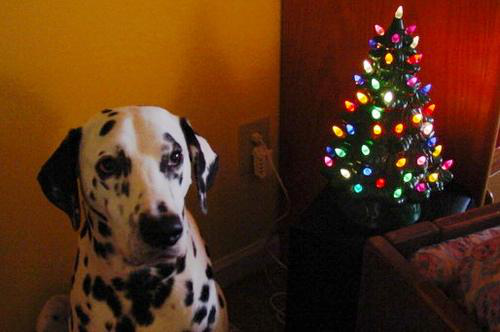

In [39]:
# Test the VGG16 predict function
from PIL import Image
img = Image.open(dog_files_short[1])
print(dog_files_short[1])
img

In [40]:
VGG16_predict_breed(dog_files_short[1])

58892288/58889256 [==============================] - 1s 0us/step


'ages/train/057.Dalmatian'

* Prediction Function is working as planned.

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

### Model Selection

According to [Keras Application](https://keras.io/api/applications/), the provided features have different accuracy, parameter, depth and requried computing time. It is notable that Xception outpeforms VGG19, ResNet50 and InceptionV3 with less parameters and depth. 

[This article](https://towardsdatascience.com/review-xception-with-depthwise-separable-convolution-better-than-inception-v3-image-dc967dd42568) succintly reviews the structure of Xception. In short, Xception is modified deptheise separable convolution, inspired by Incetpion. [This paper](https://arxiv.org/abs/1610.02357) suggests that the performance gains are not due to increased capacity but rather to a more efficient use of model parameters becuase Xception architecture has the same number of parameters as Inception V3.

The file size of pre-computed feature exceeds the capacity limit of the Udacity workspace. Thus, to test the xception model, pre-training model is downloade from keras.applications and data is pre-processed with xcepton model.

In [92]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



In [93]:
### TODO: Define your architecture.
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_12  (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [94]:
### TODO: Compile the model.
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [98]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

resnet50_history = Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=10, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 2s 248us/step - loss: 0.0929 - acc: 0.9714 - val_loss: 0.6863 - val_acc: 0.8108
Epoch 2/10
6680/6680 [==============================] - 2s 245us/step - loss: 0.0637 - acc: 0.9804 - val_loss: 0.6468 - val_acc: 0.8287
Epoch 3/10
6680/6680 [==============================] - 2s 244us/step - loss: 0.0455 - acc: 0.9880 - val_loss: 0.7698 - val_acc: 0.8024
Epoch 4/10
6680/6680 [==============================] - 2s 244us/step - loss: 0.0363 - acc: 0.9898 - val_loss: 0.7292 - val_acc: 0.8311
Epoch 5/10
6680/6680 [==============================] - 2s 244us/step - loss: 0.0280 - acc: 0.9924 - val_loss: 0.7486 - val_acc: 0.8311
Epoch 6/10
6680/6680 [==============================] - 2s 244us/step - loss: 0.0198 - acc: 0.9954 - val_loss: 0.7316 - val_acc: 0.8251
Epoch 7/10
6680/6680 [==============================] - 2s 244us/step - loss: 0.0160 - acc: 0.9964 - val_loss: 0.7767 - val_acc: 0.8168
E

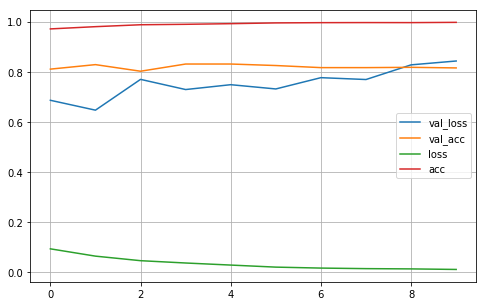

In [99]:
pd.DataFrame(resnet50_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [100]:
### TODO: Load the model weights with the best validation loss.
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [102]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 80.0239%


## Transfer Learning witout using bottleneck features provided by Udacity
In the following section, transdfer learning with Xception and Resnet50 will be trained and tested for dog breed identification without using bottleneck featuress provided by Udacity so that I can implement the transfer learning for more real world case. 

### 1. Transfer Learning with Keras for Xcetpion

In [24]:
import keras.applications.xception as xception

# preprocess images through Xception's proprocess_input() function
# after preprocssing images, store them as 4D tensor
def preprocess_xception(img_paths):
    list_of_tensors = []
    for img_path in tqdm(img_paths):
        final_image = xception.preprocess_input(path_to_tensor(img_path))
        list_of_tensors.append(final_image)
    return np.vstack(list_of_tensors)

In [25]:
# preprocess the images for xception model
train_tensors_xception = preprocess_xception(train_files)
valid_tensors_xception = preprocess_xception(valid_files)
test_tensors_xception = preprocess_xception(test_files)

100%|██████████| 836/836 [00:08<00:00, 102.15it/s]


In [26]:
### define xception model
# exclude the top of the network
base_model = xception.Xception(weights='imagenet',include_top=False)
avg = GlobalAveragePooling2D()(base_model.output)
output = Dense(133, activation="softmax")(avg)
xception_model = Model(input=base_model.input, outputs=output)

83689472/83683744 [==============================] - 1s 0us/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  


In [27]:
# freeze the weights of the pretrained layers
for layer in base_model.layers:
    layer.trainable = False

xception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [28]:
xception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [29]:
from keras.callbacks import ModelCheckpoint 
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.xception.hdf5', 
                               verbose=1, save_best_only=True)

xception_history = xception_model.fit(train_tensors_xception, train_targets, 
          validation_data=(valid_tensors_xception, valid_targets),
          epochs=10, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 110s 16ms/step - loss: 2.1231 - acc: 0.5707 - val_loss: 0.8820 - val_acc: 0.7461
Epoch 2/10
6680/6680 [==============================] - 107s 16ms/step - loss: 0.8276 - acc: 0.7838 - val_loss: 0.8354 - val_acc: 0.7605
Epoch 3/10
6680/6680 [==============================] - 107s 16ms/step - loss: 0.6288 - acc: 0.8247 - val_loss: 0.7660 - val_acc: 0.7760
Epoch 4/10
6680/6680 [==============================] - 107s 16ms/step - loss: 0.5360 - acc: 0.8479 - val_loss: 0.7595 - val_acc: 0.7856
Epoch 5/10
6680/6680 [==============================] - 106s 16ms/step - loss: 0.4930 - acc: 0.8605 - val_loss: 0.7705 - val_acc: 0.7964
Epoch 6/10
6680/6680 [==============================] - 107s 16ms/step - loss: 0.4420 - acc: 0.8720 - val_loss: 0.7282 - val_acc: 0.8000
Epoch 7/10
6680/6680 [==============================] - 107s 16ms/step - loss: 0.4114 - acc: 0.8834 - val_loss: 0.7735 - val_acc: 0

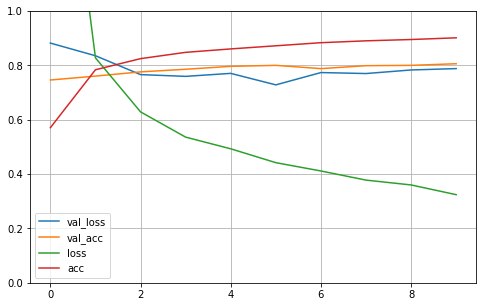

In [48]:
pd.DataFrame(xception_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.ylim(0,1)
plt.show()

In [31]:
xception_model.load_weights('saved_models/weights.best.xception.hdf5')
xception_predictions = [np.argmax(xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_tensors_xception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(xception_predictions)==np.argmax(test_targets, axis=1))/len(xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 79.6651%


* The validation loss stopped decreasing steadily only after 2 epochs and fairly decoupled with the training loss, indicating the overfitting at the very early stage of training.

### 2. Transfer Learning with Keras for ResNet50

In [38]:
import keras.applications.resnet50 as resnet50

# preprocess images through Xception's proprocess_input() function
# after preprocssing images, store them as 4D tensor
def preprocess_resnet50(img_paths):
    list_of_tensors = []
    for img_path in tqdm(img_paths):
        final_image = resnet50.preprocess_input(path_to_tensor(img_path))
        list_of_tensors.append(final_image)
    return np.vstack(list_of_tensors)

In [39]:
train_tensors_resnet50 = preprocess_resnet50(train_files)
valid_tensors_resnet50 = preprocess_resnet50(valid_files)
test_tensors_resnet50 = preprocess_resnet50(test_files)

100%|██████████| 836/836 [00:09<00:00, 85.70it/s] 


In [40]:
base_model = resnet50.ResNet50(weights='imagenet',include_top=False)
avg = GlobalAveragePooling2D()(base_model.output)
output = Dense(133, activation="softmax")(avg)
resnet50_model = Model(input=base_model.input, outputs=output)

94658560/94653016 [==============================] - 2s 0us/step


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  after removing the cwd from sys.path.


In [41]:
# freeze the weights of the pretrained layers
for layer in base_model.layers:
    layer.trainable = False

resnet50_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        input_3[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_50 (Activation)      (None, None, None, 6 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [42]:
resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [43]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.resnet50.hdf5', 
                               verbose=1, save_best_only=True)

resnet50_history = resnet50_model.fit(train_tensors_resnet50, train_targets, 
          validation_data=(valid_tensors_resnet50, valid_targets),
          epochs=10, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 116s 17ms/step - loss: 1.9820 - acc: 0.5165 - val_loss: 0.9923 - val_acc: 0.6994
Epoch 2/10
6680/6680 [==============================] - 110s 16ms/step - loss: 0.6157 - acc: 0.8117 - val_loss: 0.8549 - val_acc: 0.7509
Epoch 3/10
6680/6680 [==============================] - 110s 16ms/step - loss: 0.4058 - acc: 0.8725 - val_loss: 0.8294 - val_acc: 0.7593
Epoch 4/10
6680/6680 [==============================] - 110s 16ms/step - loss: 0.2862 - acc: 0.9079 - val_loss: 0.8238 - val_acc: 0.7689
Epoch 5/10
6680/6680 [==============================] - 109s 16ms/step - loss: 0.2212 - acc: 0.9292 - val_loss: 0.8054 - val_acc: 0.7820
Epoch 6/10
6680/6680 [==============================] - 109s 16ms/step - loss: 0.1712 - acc: 0.9460 - val_loss: 0.8518 - val_acc: 0.7653
Epoch 7/10
6680/6680 [==============================] - 109s 16ms/step - loss: 0.1408 - acc: 0.9554 - val_loss: 0.8323 - val_acc: 0

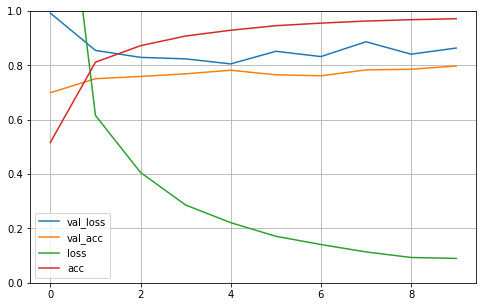

In [57]:
pd.DataFrame(resnet50_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.ylim(0,1)
plt.show()

In [45]:
resnet50_model.load_weights('saved_models/weights.best.resnet50.hdf5')
resnet50_predictions = [np.argmax(resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_tensors_resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(resnet50_predictions)==np.argmax(test_targets, axis=1))/len(resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 78.3493%


* The transfer learning was successfully implemented and both models produce similar accuracy.
* The learning cureve of ResNet50 pre-trained model shows that the steady decrease of validation loss stopped only after 1 epoch. On the other hand, the training loss keep decreasing lower than Xception model. These obeservation implies that ResNet50 might be more prone to overfitting with the provided dataset than Xception.
* To improve the model further, the image augmentation will be tested with Xception pre-trained model.

### 3. Transfer Learning with Xception combined with image augmentation

In [50]:
base_model = xception.Xception(weights='imagenet',include_top=False)
avg = GlobalAveragePooling2D()(base_model.output)
output = Dense(133, activation="softmax")(avg)
xception_aug_model = Model(input=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

xception_aug_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# create and confiture augmented image generator
datagen_train = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

# fit augmented image generator on data
batch_size = 16
datagen_train.fit(train_tensors_xception)

# train the model
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.xception_aug.hdf5', 
                               verbose=1, save_best_only=True)

xception_aug_history = xception_aug_model.fit_generator(datagen_train.flow(train_tensors_xception, train_targets,batch_size=batch_size),
                   steps_per_epoch=train_tensors_xception.shape[0]//batch_size,
                   epochs=10, verbose=1, callbacks=[checkpointer],
                   validation_data=(valid_tensors_xception, valid_targets),
                   validation_steps=valid_tensors_xception.shape[0]//batch_size)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  after removing the cwd from sys.path.


Epoch 1/10
417/417 [==============================] - 118s 282ms/step - loss: 2.6559 - acc: 0.4568 - val_loss: 1.0785 - val_acc: 0.7078
Epoch 2/10
417/417 [==============================] - 109s 262ms/step - loss: 1.3999 - acc: 0.6400 - val_loss: 0.8845 - val_acc: 0.7653
Epoch 3/10
417/417 [==============================] - 109s 262ms/step - loss: 1.1786 - acc: 0.6854 - val_loss: 0.7466 - val_acc: 0.7725
Epoch 4/10
417/417 [==============================] - 110s 263ms/step - loss: 1.1165 - acc: 0.6981 - val_loss: 0.7161 - val_acc: 0.7844
Epoch 5/10
417/417 [==============================] - 110s 263ms/step - loss: 1.0428 - acc: 0.7208 - val_loss: 0.6858 - val_acc: 0.7940
Epoch 6/10
417/417 [==============================] - 110s 264ms/step - loss: 1.0082 - acc: 0.7322 - val_loss: 0.6763 - val_acc: 0.8024
Epoch 7/10
417/417 [==============================] - 110s 264ms/step - loss: 1.0133 - acc: 0.7251 - val_loss: 0.6720 - val_acc: 0.7976
Epoch 8/10
417/417 [============================

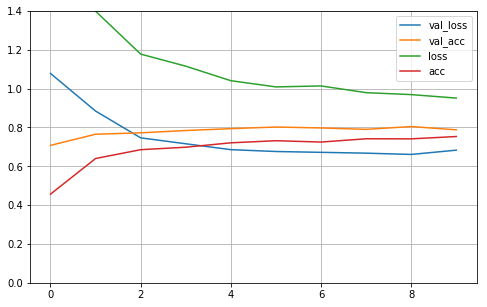

In [61]:
# plot learning curve
pd.DataFrame(xception_aug_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.ylim(0,1.4)
plt.show()

In [55]:
xception_aug_model.load_weights('saved_models/weights.best.xception_aug.hdf5')
xception_aug_predictions = [np.argmax(xception_aug_model.predict(np.expand_dims(feature, axis=0))) for feature in test_tensors_xception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(xception_aug_predictions)==np.argmax(test_targets, axis=1))/len(xception_aug_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 79.4258%


* Interestingly, the validation loss kept decreasing till epoch 6-8 albeit at slow pace.
* However, the accuracy did not improve compared to that without image augmentation.
* The small size of training data as well as the similarity of data with imagenet implies that unfreezing the weights of lower layers will not make sense. Thus, as the final attempt, only the weights of the second top layer of pre-trained Xception were unfrozen and tested with the image augmentation to see if there is any performance improvement.

In [62]:
len(base_model.layers)

132

In [68]:
i = 1
for layer in base_model.layers:
    i += 1
    if i >= 129:
        layer.trainable = True
    else:
        layer.trainable = False
        
xception_aug_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
xception_aug_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [69]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.xception_aug_unfrozen.hdf5', 
                               verbose=1, save_best_only=True)

xception_aug_history = xception_aug_model.fit_generator(datagen_train.flow(train_tensors_xception, train_targets,batch_size=batch_size),
                   steps_per_epoch=train_tensors_xception.shape[0]//batch_size,
                   epochs=10, verbose=1, callbacks=[checkpointer],
                   validation_data=(valid_tensors_xception, valid_targets),
                   validation_steps=valid_tensors_xception.shape[0]//batch_size)

Epoch 1/10
417/417 [==============================] - 117s 282ms/step - loss: 1.1266 - acc: 0.6917 - val_loss: 0.9846 - val_acc: 0.7449
Epoch 2/10
417/417 [==============================] - 115s 276ms/step - loss: 0.9110 - acc: 0.7365 - val_loss: 0.9980 - val_acc: 0.7557
Epoch 3/10
417/417 [==============================] - 115s 277ms/step - loss: 0.7353 - acc: 0.7777 - val_loss: 0.9719 - val_acc: 0.7677
Epoch 4/10
417/417 [==============================] - 115s 277ms/step - loss: 0.6782 - acc: 0.7978 - val_loss: 0.8663 - val_acc: 0.7868
Epoch 5/10
417/417 [==============================] - 115s 276ms/step - loss: 0.5981 - acc: 0.8198 - val_loss: 1.0286 - val_acc: 0.7677
Epoch 6/10
417/417 [==============================] - 115s 276ms/step - loss: 0.5575 - acc: 0.8323 - val_loss: 0.9976 - val_acc: 0.7713
Epoch 7/10
417/417 [==============================] - 115s 276ms/step - loss: 0.5096 - acc: 0.8450 - val_loss: 0.9617 - val_acc: 0.7689
Epoch 8/10
417/417 [============================

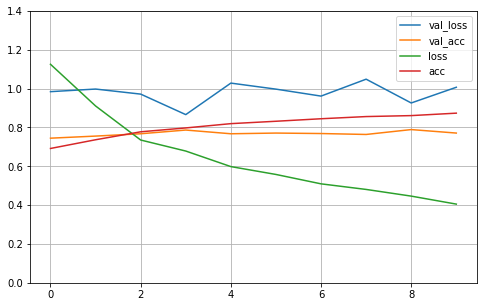

In [70]:
pd.DataFrame(xception_aug_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.ylim(0,1.4)
plt.show()

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [54]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from PIL import Image

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    #read the image
    img_input = cv2.imread(img_path)
    img_input = cv2.cvtColor(img_input, cv2.COLOR_BGR2RGB)
    # return dog breed that is predicted by the model
    predicted_breed = dog_names[np.argmax(predicted_vector)].split('.')[1]
    plt.imshow(img_input)
    plt.title('Input Image')
    plt.show()
    print('The predicted breed is: {}'.format(predicted_breed))
    return predicted_breed
   

94658560/94653016 [==============================] - 1s 0us/step


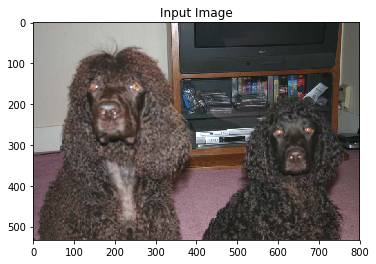

The predicted breed is: Irish_water_spaniel


'Irish_water_spaniel'

In [55]:
Resnet50_predict_breed(dog_files_short[2])

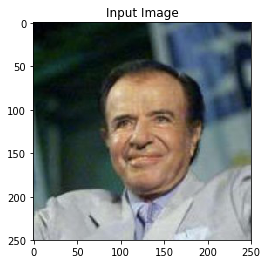

The predicted breed is: Silky_terrier


'Silky_terrier'

In [56]:
Resnet50_predict_breed(human_files_short[2])

### Prediction with Xception model without using pre-computed bottleneck features

As in the previous step, a prediction function without relying on pre-computed bottleneck features provided by the udacity is developed as follow.

In [43]:
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.models import Model
import keras.applications.xception as xception


# preprocess images through Xception's proprocess_input() function
# after preprocssing images, store them as 4D tensor
def preprocess_xception(img_paths):
    list_of_tensors = []
    for img_path in tqdm(img_paths):
        final_image = xception.preprocess_input(path_to_tensor(img_path))
        list_of_tensors.append(final_image)
    return np.vstack(list_of_tensors)

# import and load model with the parameters with the lowest validation loss
base_model = xception.Xception(weights='imagenet',include_top=False)
avg = GlobalAveragePooling2D()(base_model.output)
output = Dense(133, activation="softmax")(avg)
xception_aug_model = Model(input=base_model.input, outputs=output)
xception_aug_model.load_weights('saved_models/weights.best.xception_aug.hdf5')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


In [44]:
def Xception_predict_breed(img_path):
    # Preprocess 4D tensor of img_path for xception model
    xception_input = xception.preprocess_input(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = xception_aug_model.predict(xception_input)
    #read the image
    img_input = cv2.imread(img_path)
    img_input = cv2.cvtColor(img_input, cv2.COLOR_BGR2RGB)
    # return dog breed that is predicted by the model
    predicted_breed = dog_names[np.argmax(predicted_vector)].split('.')[1]
    plt.imshow(img_input)
    plt.title('Input Image')
    plt.show()
    print('The predicted breed is: {}'.format(predicted_breed))
    return predicted_breed

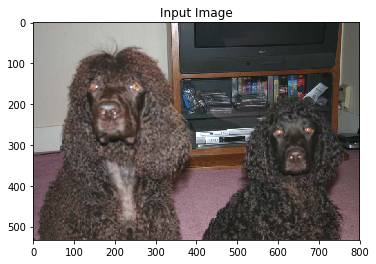

The predicted breed is: Irish_water_spaniel


'Irish_water_spaniel'

In [45]:
Xception_predict_breed(dog_files_short[2])

In [46]:
dog_files_short[2].split('/')[-2].split('.')[1]

'Irish_water_spaniel'

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

A sample image and output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_2.png)

This photo looks like an Afghan Hound.
### (IMPLEMENTATION) Write your Algorithm

In [47]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def dog_app_xception(img_path):
    ''' The function of dog detection from an image file. The algorithm uses the
    convolutional neural network. The function first deternmines whether the image 
    contains a human, dog, or neither. Then, the function will return as follows:
    
        - if a dog is detected in the image, return the predicted breed.
        - if a human is detected in the image, return the resembling dog breed.
        - if neither is detected in the image, provide output that indicates an error.
    
    Args:
        img_path: an image to be analyzed
        
    Returns:
        str: predicted breed if dog or human image is detected. If neither is dectected, error
        message will be returend.
    '''
    if dog_detector(img_path):
        print('dog image is detected.')
        Xception_predict_breed(img_path)
    
    elif face_detector(img_path):
        print('human image is detected. We will give you the most resembling dog to this human')
        Xception_predict_breed(img_path)
        
    else:
        print('error: neither dog nor human image was detected. Please input a dog or human image.')
        img_input = cv2.imread(img_path)
        img_input = cv2.cvtColor(img_input, cv2.COLOR_BGR2RGB)
        plt.imshow(img_input)
        plt.title('Neither human nor dog')
        plt.show()

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

dog image is detected.


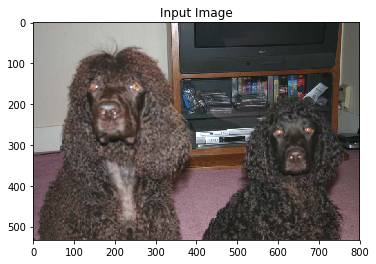

The predicted breed is: Irish_water_spaniel


In [48]:
dog_app_xception(dog_files_short[2])

human image is detected. We will give you the most resembling dog to this human


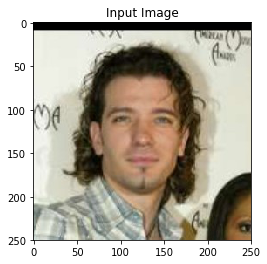

The predicted breed is: Giant_schnauzer


In [49]:
dog_app_xception(human_files_short[1])

human image is detected. We will give you the most resembling dog to this human


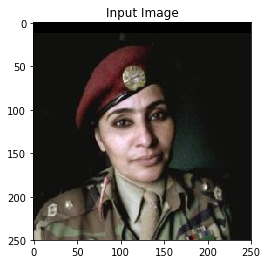

The predicted breed is: Giant_schnauzer


In [50]:
dog_app_xception(human_files_short[3])

In [51]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

dog image is detected.


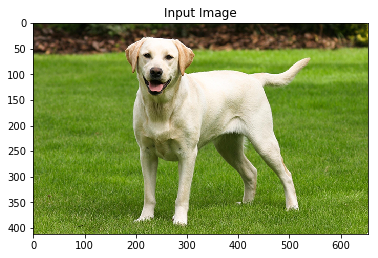

The predicted breed is: Labrador_retriever


In [60]:
dog_app_xception("./images/labrador.png")

dog image is detected.


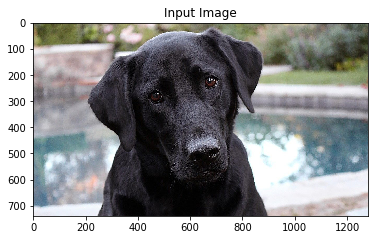

The predicted breed is: Labrador_retriever


In [63]:
dog_app_xception("./images/black_labrador.jpg")

dog image is detected.


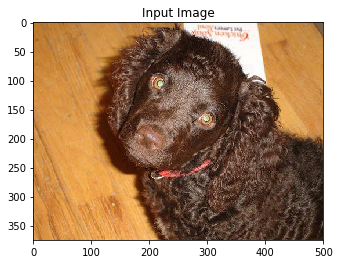

The predicted breed is: American_water_spaniel


In [64]:
dog_app_xception("./images/American_water_spaniel_00648.jpg")

dog image is detected.


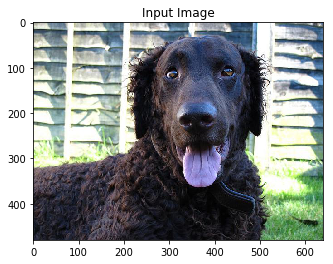

The predicted breed is: Curly-coated_retriever


In [65]:
dog_app_xception("./images/Curly-coated_retriever_03896.jpg")

dog image is detected.


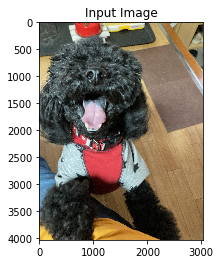

The predicted breed is: Portuguese_water_dog


In [53]:
dog_app_xception("./images/coco.jpeg")

human image is detected. We will give you the most resembling dog to this human


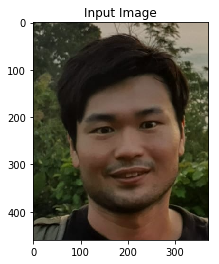

The predicted breed is: Glen_of_imaal_terrier


In [66]:
dog_app_xception("./images/nori2.png")

human image is detected. We will give you the most resembling dog to this human


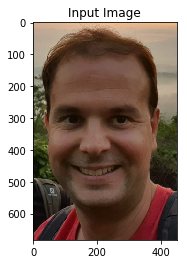

The predicted breed is: Lhasa_apso


In [67]:
dog_app_xception("./images/igor.png")

error: neither dog nor human image was detected. Please input a dog or human image.


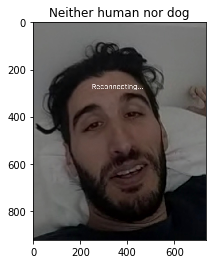

In [68]:
dog_app_xception("./images/tommy2.png")

human image is detected. We will give you the most resembling dog to this human


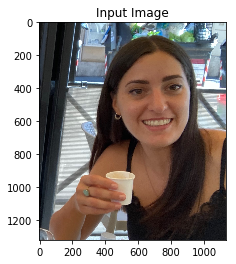

The predicted breed is: Havanese


In [69]:
dog_app_xception("./images/giulia.png")

human image is detected. We will give you the most resembling dog to this human


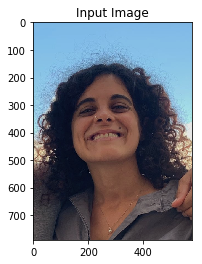

The predicted breed is: Irish_water_spaniel


In [70]:
dog_app_xception("./images/chiara.png")